In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [8]:
pred_keys = {'BayesSpace': 'spatial.cluster',
             'conST': 'refine',
             'DeepST': 'DeepST_refine_domain',
             'GraphST': 'domain',
             'PRECAST': 'cluster',
             'SEDR': 'SEDR',
             'Seurat': 'seurat_clusters',
             'SpaceFlow': 'pred',
             'SpaGCN': 'refined_pred',
             'STAGATE': 'STAGATE',
             'stLearn': 'X_pca_kmeans'}

In [9]:
method = 'PRECAST'
pred_key = pred_keys[method]
dataset = 'BRCA1'

data_folder = f'../data/{dataset}'
input_dir = f'../Results/results_old/{dataset}/{method}'
out_path = f'../Results/results_trajectory/{dataset}/{method}'
os.makedirs(out_path, exist_ok=True)

file = input_dir
section_id = 'V1_Human_Breast_Cancer_Block_A_Section_1'

file_path = os.path.join(data_folder, section_id)
print(method)

PRECAST


In [10]:
from scipy.optimize import linear_sum_assignment
def assign_labels(adata):
    gt = adata.obs['gt'].values
    pred = adata.obs['pred'].values

    gt_labels = np.unique(gt)
    pred_labels = np.unique(pred)
    
    contingency_table = pd.crosstab(gt, pred).reindex(index=gt_labels, columns=pred_labels, fill_value=0)

    # Hungarian matching
    cost_matrix = -contingency_table.values.T # To map pred -> gt
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {pred_labels[row]: gt_labels[col] for row, col in zip(row_ind, col_ind)}

    # Greedy matching
    # mapping = contingency_table.idxmax(axis=1).to_dict()

    adata.obs['labels'] = adata.obs['pred'].map(mapping)

    print(contingency_table)
    print(contingency_table.shape)
    print(mapping)
    return adata

In [11]:
def process_adata(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    return adata

import matplotlib.patches as mpatches
def plot_trajectory(adata, out_path):
    fix, ax = plt.subplots(figsize=(10, 10))
    sc.tl.paga(adata, groups='labels')
    sc.pl.paga(
        adata, 
        show=False, 
        plot=True,
        fontsize=0,
        ax=ax,
        text_kwds={"color": "#555555"}
    )
    #  Remove plot borders (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    unique_labels = list(adata.obs['labels'].cat.categories)  # Get unique labels
    colors = adata.uns.get("labels_colors") 

    # Create legend with the same colors as the nodes
    legend_patches = [mpatches.Patch(color=colors[i], label=unique_labels[i]) for i in range(len(unique_labels))]
    ax.legend(handles=legend_patches, loc='center left', fontsize=13, bbox_to_anchor=(1, 0.5), frameon=False)

    # Save the figure
    plt.savefig(os.path.join(out_path, 'trajectory.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(out_path, 'trajectory.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

================= Processing PRECAST BRCA1 =================
col_0          1   10   11   12   13   14  15  16  17   18  19   2  20   3  \
row_0                                                                        
DCIS/LCIS_1    0    0  134    0    0    0   0   0   0    0   0   0   0   0   
DCIS/LCIS_2    0    1   25    0    0    0   0   0   0    0   1   0   0   0   
DCIS/LCIS_3    1    0    0    0  326    0   0   0   0    0   0   0   0  37   
DCIS/LCIS_4    0    0    0    0    0  151   1   0   0    0   1   0   2   0   
DCIS/LCIS_5    0    0   75    0    1   13   0   0   0    0   0   0   0   0   
Healthy_1     52  230    0    0    0    0   1   3   0    0   0  99   0   0   
Healthy_2      0    0    0    0    4    0   0   0   1    0   0   0   2   4   
IDC_1          1    0    0    0    0    0   2   0  33    0   0   0   2   0   
IDC_2          1    0    0    0    0    2   0   0   0  128   8   0   1   0   
IDC_3          0    0    0    0    0    1   2  24   0    0   0   0   0   0   
IDC

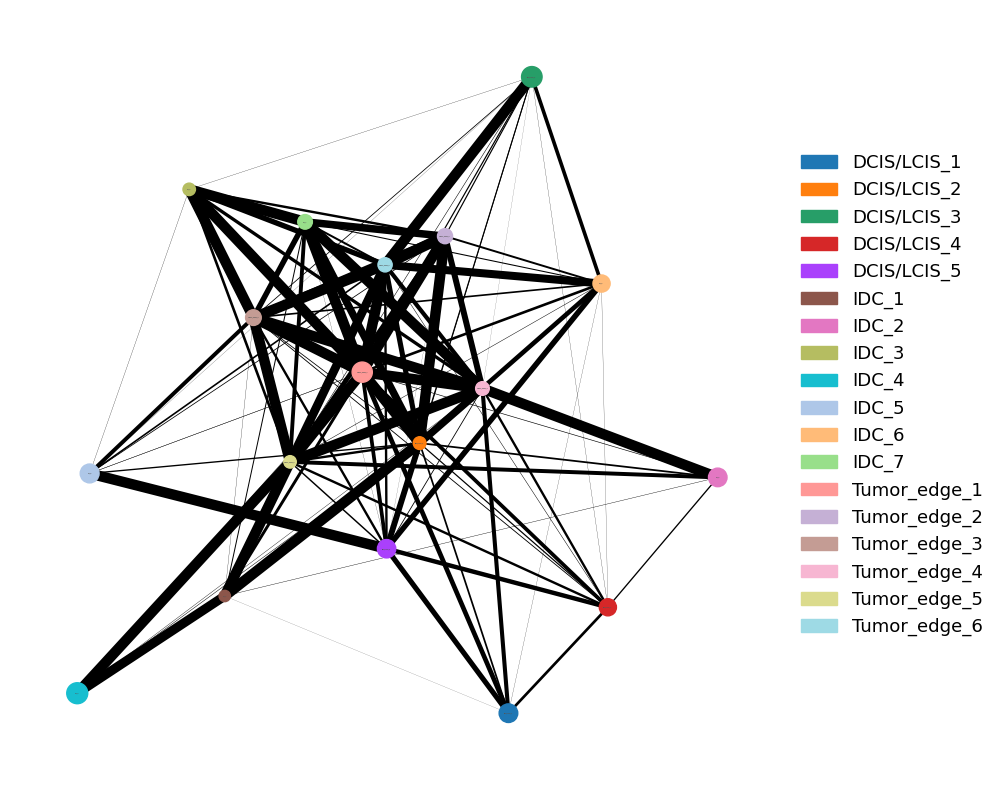

    Results saved to ../Results/results_trajectory/BRCA1/PRECAST
================= Finished PRECAST BRCA1 =================


In [12]:
print(f'================= Processing {method} {dataset} =================')

adata = sc.read_visium(file_path)
adata.var_names_make_unique()
metadata = pd.read_csv(file + '/cell_metadata.csv', index_col=0)
gt_metadata = pd.read_csv(os.path.join(file_path, 'metadata.tsv'), sep='\t', index_col=0)

adata.obs['gt'] = gt_metadata['fine_annot_type'].values
adata = adata[~pd.isnull(adata.obs['gt'])]

# Match adata and metadata 
adata = adata[adata.obs.index.isin(metadata.index)]
metadata = metadata.loc[adata.obs.index]
gt_metadata = gt_metadata.loc[adata.obs.index]

# metadata = metadata.set_index(['array_row', 'array_col'])
# adata.obs = adata.obs.set_index(['array_row', 'array_col'])
# metadata = metadata.loc[adata.obs.index]


pred = metadata[pred_key].values
if min(pred) == 0:
    pred += 1

adata.obs['pred'] = pred.astype(str)
adata.obs['gt'] = adata.obs['gt'].astype(str)

adata = assign_labels(adata)
print('Shape of adata:', adata.shape)

# Remove Healthy_1 and Healthy_2
adata = adata[~adata.obs['labels'].isin(['Healthy_1', 'Healthy_2'])] 
print('Shape of adata after removing Healthy_1 and Healthy_2:', adata.shape)

adata = process_adata(adata)
plot_trajectory(adata, out_path)
print(f'    Results saved to {out_path}')
# break

print(f'================= Finished {method} {dataset} =================')